In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

import time
import datetime as dt

from sklearn import preprocessing

In [2]:
data = pd.read_csv("tsharep.csv",encoding=' big5-hkscs ').rename(columns={'代碼':'code','日期':'date','中文簡稱':'name','開盤價(元)':'open','最高價(元)':'high','最低價(元)':'low','收盤價(元)':'close','成交張數(張)':'volumn'})
data.head()

,code,date,name,open,high,low,close,volumn
0,1101,20130102,台泥,38.95,39.1,38.65,39,"6,374"
1,1101,20130103,台泥,39.5,39.5,38.75,38.85,"9,710"
2,1101,20130104,台泥,39.4,39.45,38.6,39,"8,682"
3,1101,20130107,台泥,39.1,39.1,38.65,38.9,"5,067"
4,1101,20130108,台泥,38.9,39.1,38.2,38.5,"6,454"


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1983973 entries, 0 to 1983972
Data columns (total 8 columns):
code      int64
date      int64
name      object
open      object
high      object
low       object
close     object
volumn    object
dtypes: int64(2), object(6)
memory usage: 121.1+ MB


In [4]:
data[data['code']==1101].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1286 entries, 0 to 1285
Data columns (total 8 columns):
code      1286 non-null int64
date      1286 non-null int64
name      1286 non-null object
open      1286 non-null object
high      1286 non-null object
low       1286 non-null object
close     1286 non-null object
volumn    1286 non-null object
dtypes: int64(2), object(6)
memory usage: 90.4+ KB


# The Constituent stocks data of Taiwan50

In [5]:
ETF = pd.read_excel('ETF50.xlsx')
ETF.head()

,code,name,propotion,count
0,1101,台泥,0.89,9229402
1,1102,亞泥,0.45,6031255
2,1216,統一,2.09,12466660
3,1301,台塑,3.12,12662673
4,1303,南亞,2.82,14682316


In [6]:
ETF50 = ETF['code'].values
ETF50_df = data[data['code']==1101]
for i in ETF50[1:]:
    temp = data[data['code']== i]
    ETF50_df = pd.concat([ETF50_df,temp],axis = 0)
    
ETF50_df.head()

,code,date,name,open,high,low,close,volumn
0,1101,20130102,台泥,38.95,39.1,38.65,39,"6,374"
1,1101,20130103,台泥,39.5,39.5,38.75,38.85,"9,710"
2,1101,20130104,台泥,39.4,39.45,38.6,39,"8,682"
3,1101,20130107,台泥,39.1,39.1,38.65,38.9,"5,067"
4,1101,20130108,台泥,38.9,39.1,38.2,38.5,"6,454"


#### Turn date to datetime，and add week data

In [7]:
ETF50_df['date'] = ETF50_df['date'].map(lambda x:dt.datetime.strptime(str(x),'%Y%m%d'))
ETF50_df['week'] = ETF50_df['date'].map(lambda x:x.isoweekday())
ETF50_df.head()

,code,date,name,open,high,low,close,volumn,week
0,1101,2013-01-02,台泥,38.95,39.1,38.65,39,"6,374",3
1,1101,2013-01-03,台泥,39.5,39.5,38.75,38.85,"9,710",4
2,1101,2013-01-04,台泥,39.4,39.45,38.6,39,"8,682",5
3,1101,2013-01-07,台泥,39.1,39.1,38.65,38.9,"5,067",1
4,1101,2013-01-08,台泥,38.9,39.1,38.2,38.5,"6,454",2


### Add higher or lower
make higher **+1** and lower **-1** and the others **0**

Becareful that some of the data has the wrong type


In [8]:
ETF50_df['close'] = ETF50_df['close'].map(lambda x:x if (type(x)==float) else float(x.replace(',','')) )

In [9]:
def sign(x):
    if (x>0):
        return 1
    elif(x<0):
        return -1
    else :
        return 0

In [10]:
aa = ETF50_df[['code','close']].values
temp = []
for i,value in enumerate(aa):
    if (i==0):
        temp.append(0)
    elif (aa[i][0]!=aa[i-1][0]):
        temp.append(0)
    else:
        temp.append(sign(aa[i][1]-aa[i-1][1]))
ETF50_df['high_low'] = temp
ETF50_df.head()

,code,date,name,open,high,low,close,volumn,week,high_low
0,1101,2013-01-02,台泥,38.95,39.1,38.65,39.00,"6,374",3,0
1,1101,2013-01-03,台泥,39.5,39.5,38.75,38.85,"9,710",4,-1
2,1101,2013-01-04,台泥,39.4,39.45,38.6,39.00,"8,682",5,1
3,1101,2013-01-07,台泥,39.1,39.1,38.65,38.90,"5,067",1,-1
4,1101,2013-01-08,台泥,38.9,39.1,38.2,38.50,"6,454",2,-1


### Mix constituent stocks data to Taiwan50 

In [11]:
ETF50_df['propotion'] = ETF50_df['code'].map(lambda x: ETF[ETF['code']==x]['propotion'].values[0])
ETF50_df['weight'] = ETF50_df['close']*ETF50_df['propotion']*0.01
ETF50_df.head()

,code,date,name,open,high,low,close,volumn,week,high_low,propotion,weight
0,1101,2013-01-02,台泥,38.95,39.1,38.65,39.00,"6,374",3,0,0.89,0.347100
1,1101,2013-01-03,台泥,39.5,39.5,38.75,38.85,"9,710",4,-1,0.89,0.345765
2,1101,2013-01-04,台泥,39.4,39.45,38.6,39.00,"8,682",5,1,0.89,0.347100
3,1101,2013-01-07,台泥,39.1,39.1,38.65,38.90,"5,067",1,-1,0.89,0.346210
4,1101,2013-01-08,台泥,38.9,39.1,38.2,38.50,"6,454",2,-1,0.89,0.342650


In [12]:
ETF50_weight_df = ETF50_df[['date','weight']].groupby(['date']).sum()
ETF50_weight_df.head()

,weight
date,
2013-01-02,96.701516
2013-01-03,97.180013
2013-01-04,96.148415
2013-01-07,94.226579
2013-01-08,93.841658


# ETF data 



In [44]:
ETFtable = pd.read_csv('tetfp.csv',encoding=' big5-hkscs ').rename(columns={'代碼':'code','日期':'date','中文簡稱':'name','開盤價(元)':'open','最高價(元)':'high','最低價(元)':'low','收盤價(元)':'close','成交張數(張)':'volume'})
ETFtable.head()

,code,date,name,open,high,low,close,volume
0,50,20130102,元大台灣50,54.00,54.65,53.90,54.40,"16,487"
1,50,20130103,元大台灣50,54.90,55.05,54.65,54.85,"29,020"
2,50,20130104,元大台灣50,54.85,54.85,54.40,54.50,"9,837"
3,50,20130107,元大台灣50,54.55,54.55,53.90,54.25,"8,910"
4,50,20130108,元大台灣50,54.00,54.20,53.65,53.90,"12,507"


#### do some adjustment
1. date : str -> datetime
2. add week
3. close,open,high,low,volume: str or float -> float
4. add high_low

In [45]:
ETFtable['date'] = ETFtable['date'].map(lambda x:dt.datetime.strptime(str(x),'%Y%m%d'))
ETFtable['week'] = ETFtable['date'].map(lambda x:x.isoweekday())
ETFtable['close'] = ETFtable['close'].map(lambda x:x if (type(x)==float) else float(x.replace(',','')) )
ETFtable['open'] = ETFtable['open'].map(lambda x:x if (type(x)==float) else float(x.replace(',','')) )
ETFtable['high'] = ETFtable['high'].map(lambda x:x if (type(x)==float) else float(x.replace(',','')) )
ETFtable['low'] = ETFtable['low'].map(lambda x:x if (type(x)==float) else float(x.replace(',','')) )
ETFtable['volume'] = ETFtable['volume'].map(lambda x:x if (type(x)==float) else float(x.replace(',','')) )

aa = ETFtable[['code','close']].values
temp = []
for i,value in enumerate(aa):
    if (i==0):
        temp.append(0)
    elif (aa[i][0]!=aa[i-1][0]):
        temp.append(0)
    else:
        temp.append(sign(aa[i][1]-aa[i-1][1]))
ETFtable['high_low'] = temp

ETFtable.head()

,code,date,name,open,high,low,close,volume,week,high_low
0,50,2013-01-02,元大台灣50,54.00,54.65,53.90,54.40,16487.0,3,0
1,50,2013-01-03,元大台灣50,54.90,55.05,54.65,54.85,29020.0,4,1
2,50,2013-01-04,元大台灣50,54.85,54.85,54.40,54.50,9837.0,5,-1
3,50,2013-01-07,元大台灣50,54.55,54.55,53.90,54.25,8910.0,1,-1
4,50,2013-01-08,元大台灣50,54.00,54.20,53.65,53.90,12507.0,2,-1


# Yunta50 data


In [59]:
Yunta50 = ETFtable[ETFtable['code']==50].drop(['code','name'],axis = 1)
Yunta50.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1286 entries, 0 to 1285
Data columns (total 8 columns):
date        1286 non-null datetime64[ns]
open        1286 non-null float64
high        1286 non-null float64
low         1286 non-null float64
close       1286 non-null float64
volume      1286 non-null float64
week        1286 non-null int64
high_low    1286 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 90.4 KB


In [60]:
Yunta50['Taiwan_50'] = ETF50_weight_df['weight'].values
Yunta50.head()

,date,open,high,low,close,volume,week,high_low,Taiwan_50
0,2013-01-02,54.00,54.65,53.90,54.40,16487.0,3,0,96.701516
1,2013-01-03,54.90,55.05,54.65,54.85,29020.0,4,1,97.180013
2,2013-01-04,54.85,54.85,54.40,54.50,9837.0,5,-1,96.148415
3,2013-01-07,54.55,54.55,53.90,54.25,8910.0,1,-1,94.226579
4,2013-01-08,54.00,54.20,53.65,53.90,12507.0,2,-1,93.841658


### Correlation of feature

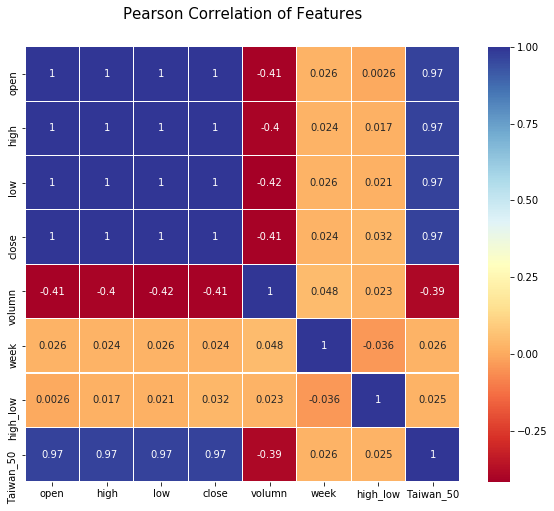

In [17]:
colormap = plt.cm.RdYlBu
plt.figure(figsize=(10,8))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(Yunta50.drop(['date'],axis = 1).astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

### Input the last 7 days data into Yuanta50

In [61]:
Yunta50['-1day_close'] = Yunta50['close'].astype(np.float64).shift(1).fillna(0)
Yunta50['-2day_close'] = Yunta50['close'].astype(np.float64).shift(2).fillna(0)
Yunta50['-3day_close'] = Yunta50['close'].astype(np.float64).shift(3).fillna(0)
Yunta50['-4day_close'] = Yunta50['close'].astype(np.float64).shift(4).fillna(0)
Yunta50['-5day_close'] = Yunta50['close'].astype(np.float64).shift(5).fillna(0)
Yunta50['-6day_close'] = Yunta50['close'].astype(np.float64).shift(6).fillna(0)
Yunta50['-7day_close'] = Yunta50['close'].astype(np.float64).shift(7).fillna(0)
Yunta50['-1day_volume'] = Yunta50['volume'].astype(np.float64).shift(1).fillna(0)
Yunta50['-2day_volume'] = Yunta50['volume'].astype(np.float64).shift(2).fillna(0)
Yunta50['-3day_volume'] = Yunta50['volume'].astype(np.float64).shift(3).fillna(0)
Yunta50['-4day_volume'] = Yunta50['volume'].astype(np.float64).shift(4).fillna(0)
Yunta50['-5day_volume'] = Yunta50['volume'].astype(np.float64).shift(5).fillna(0)
Yunta50['-6day_volume'] = Yunta50['volume'].astype(np.float64).shift(6).fillna(0)
Yunta50['-7day_volume'] = Yunta50['volume'].astype(np.float64).shift(7).fillna(0)
Yunta50['20day_mean'] = Yunta50['close'].rolling(window=20,min_periods=20).mean().fillna(0)
Yunta50.head()

,date,open,high,low,close,volume,week,high_low,Taiwan_50,-1day_close,...,-6day_close,-7day_close,-1day_volume,-2day_volume,-3day_volume,-4day_volume,-5day_volume,-6day_volume,-7day_volume,20day_mean
0,2013-01-02,54.00,54.65,53.90,54.40,16487.0,3,0,96.701516,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-03,54.90,55.05,54.65,54.85,29020.0,4,1,97.180013,54.40,...,0.0,0.0,16487.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-04,54.85,54.85,54.40,54.50,9837.0,5,-1,96.148415,54.85,...,0.0,0.0,29020.0,16487.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-01-07,54.55,54.55,53.90,54.25,8910.0,1,-1,94.226579,54.50,...,0.0,0.0,9837.0,29020.0,16487.0,0.0,0.0,0.0,0.0,0.0
4,2013-01-08,54.00,54.20,53.65,53.90,12507.0,2,-1,93.841658,54.25,...,0.0,0.0,8910.0,9837.0,29020.0,16487.0,0.0,0.0,0.0,0.0


In [62]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))    
    df['Taiwan_50'] = min_max_scaler.fit_transform(df['Taiwan_50'].values.reshape(-1,1))
    df['-1day_close'] = min_max_scaler.fit_transform(df['-1day_close'].values.reshape(-1,1))
    df['-2day_close'] = min_max_scaler.fit_transform(df['-2day_close'].values.reshape(-1,1))
    df['-3day_close'] = min_max_scaler.fit_transform(df['-3day_close'].values.reshape(-1,1))
    df['-4day_close'] = min_max_scaler.fit_transform(df['-4day_close'].values.reshape(-1,1))
    df['-5day_close'] = min_max_scaler.fit_transform(df['-5day_close'].values.reshape(-1,1))
    df['-6day_close'] = min_max_scaler.fit_transform(df['-6day_close'].values.reshape(-1,1))
    df['-7day_close'] = min_max_scaler.fit_transform(df['-7day_close'].values.reshape(-1,1))
    df['-1day_volume'] = min_max_scaler.fit_transform(df['-1day_volume'].values.reshape(-1,1))
    df['-2day_volume'] = min_max_scaler.fit_transform(df['-2day_volume'].values.reshape(-1,1))
    df['-3day_volume'] = min_max_scaler.fit_transform(df['-3day_volume'].values.reshape(-1,1))
    df['-4day_volume'] = min_max_scaler.fit_transform(df['-4day_volume'].values.reshape(-1,1))
    df['-5day_volume'] = min_max_scaler.fit_transform(df['-5day_volume'].values.reshape(-1,1))
    df['-6day_volume'] = min_max_scaler.fit_transform(df['-6day_volume'].values.reshape(-1,1))
    df['-7day_volume'] = min_max_scaler.fit_transform(df['-7day_volume'].values.reshape(-1,1))
    df['20day_mean'] = min_max_scaler.fit_transform(df['20day_mean'].values.reshape(-1,1))

Yunta50N = Yunta50.copy() 
normalize_data(Yunta50N)
Yunta50N.head()

,date,open,high,low,close,volume,week,high_low,Taiwan_50,-1day_close,...,-6day_close,-7day_close,-1day_volume,-2day_volume,-3day_volume,-4day_volume,-5day_volume,-6day_volume,-7day_volume,20day_mean
0,2013-01-02,0.020144,0.032951,0.027182,0.039660,0.259106,3,0,0.022804,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,2013-01-03,0.046043,0.044413,0.048641,0.052408,0.466236,4,1,0.025627,0.616082,...,0.0,0.0,0.268881,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,2013-01-04,0.044604,0.038682,0.041488,0.042493,0.149203,5,-1,0.019541,0.621178,...,0.0,0.0,0.473278,0.268881,0.000000,0.000000,0.0,0.0,0.0,0.0
3,2013-01-07,0.035971,0.030086,0.027182,0.035411,0.133883,1,-1,0.008204,0.617214,...,0.0,0.0,0.160429,0.473278,0.268881,0.000000,0.0,0.0,0.0,0.0
4,2013-01-08,0.020144,0.020057,0.020029,0.025496,0.193330,2,-1,0.005934,0.614383,...,0.0,0.0,0.145310,0.160429,0.473278,0.268881,0.0,0.0,0.0,0.0


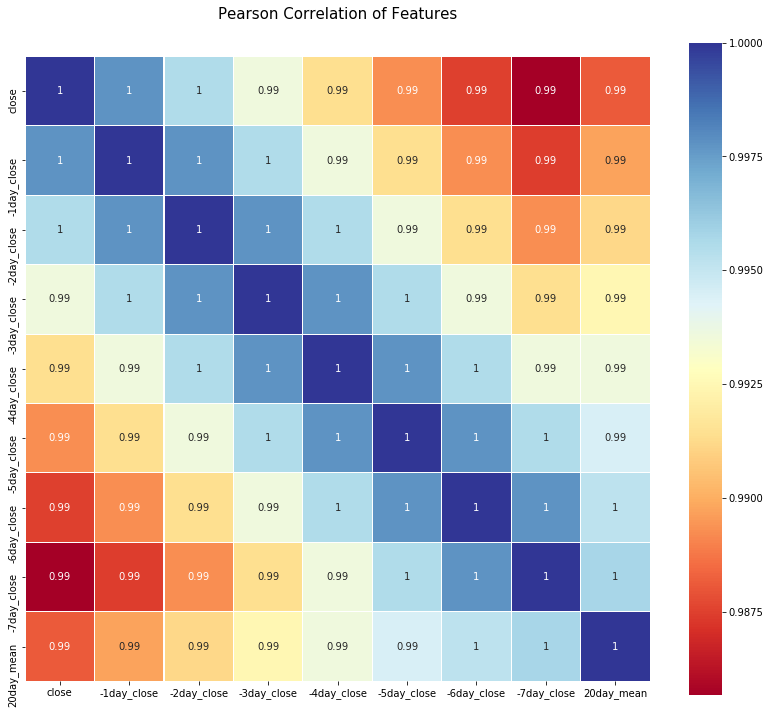

In [63]:
colormap = plt.cm.RdYlBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(Yunta50N[['close','-1day_close','-2day_close','-3day_close','-4day_close','-5day_close','-6day_close','-7day_close','20day_mean']][20:].astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

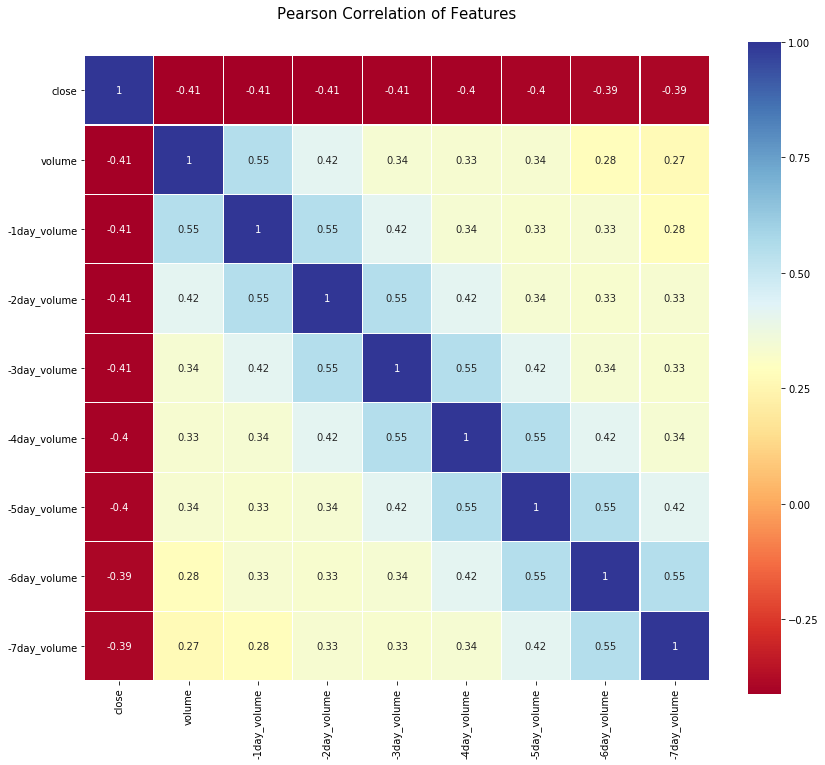

In [64]:
colormap = plt.cm.RdYlBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(Yunta50N[['close','volume','-1day_volume','-2day_volume','-3day_volume','-4day_volume','-5day_volume','-6day_volume','-7day_volume']][20:].astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

# One day price prediction

In [18]:
Yunta50_ = table[table['code']==50].drop(['code','name'],axis = 1)
Yunta50_['Taiwan_50'] = ETF50_weight_df['weight'].values
t = Yunta50_['close'].values
Yunta50_.drop(['close'],axis=1,inplace = True)
Yunta50_['close'] = t
Yunta50_.drop(['week','high_low'],axis=1,inplace = True)
Yunta50_ = Yunta50_.groupby(['date']).sum()
Yunta50_.head()

,open,high,low,volumn,Taiwan_50,close
date,,,,,,
2013-01-02,54.00,54.65,53.90,16487.0,96.701516,54.40
2013-01-03,54.90,55.05,54.65,29020.0,97.180013,54.85
2013-01-04,54.85,54.85,54.40,9837.0,96.148415,54.50
2013-01-07,54.55,54.55,53.90,8910.0,94.226579,54.25
2013-01-08,54.00,54.20,53.65,12507.0,93.841658,53.90


## Normalize data

In [19]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volumn'] = min_max_scaler.fit_transform(df.volumn.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))    
    df['Taiwan_50'] = min_max_scaler.fit_transform(df['Taiwan_50'].values.reshape(-1,1))
#     df['week'] = min_max_scaler.fit_transform(df['week'].values.reshape(-1,1))

Yunta50_N = Yunta50_.copy() 
normalize_data(Yunta50_N)
Yunta50_N.head()

,open,high,low,volumn,Taiwan_50,close
date,,,,,,
2013-01-02,0.020144,0.032951,0.027182,0.259106,0.022804,0.039660
2013-01-03,0.046043,0.044413,0.048641,0.466236,0.025627,0.052408
2013-01-04,0.044604,0.038682,0.041488,0.149203,0.019541,0.042493
2013-01-07,0.035971,0.030086,0.027182,0.133883,0.008204,0.035411
2013-01-08,0.020144,0.020057,0.020029,0.193330,0.005934,0.025496


## Generalize X , Y

use twenty days data as features

In [113]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) 
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 20days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] #make the last day of train data as y_train
    y_train = train[:, -1][:,-1] #the close price of the last day of every data 
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = x_train.reshape((x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
    x_test =  x_test.reshape((x_test.shape[0],x_test.shape[1]*x_test.shape[2]))
     

    return [x_train, y_train, x_test, y_test]

In [21]:
window = 20
X_train, y_train, X_test, y_test = load_data(Yunta50_N, window)
print (X_train[0], y_train[0])

[0.02014388 0.03295129 0.02718169 0.25910623 0.0228042  0.03966006
 0.04604317 0.04441261 0.04864092 0.46623587 0.02562692 0.05240793
 0.04460432 0.03868195 0.04148784 0.14920341 0.01954138 0.04249292
 0.03597122 0.03008596 0.02718169 0.13388312 0.00820422 0.03541076
 0.02014388 0.02005731 0.02002861 0.19332981 0.00593352 0.02549575
 0.01294964 0.02292264 0.02288984 0.11105969 0.00889324 0.03116147
 0.02877698 0.03295129 0.03433476 0.21722747 0.01215765 0.04249292
 0.04028777 0.03724928 0.04005722 0.18225689 0.01419854 0.04107649
 0.02014388 0.0286533  0.02432046 0.10697759 0.01127164 0.04249292
 0.02589928 0.02722063 0.02718169 0.09585509 0.00632166 0.02832861
 0.02158273 0.01575931 0.02145923 0.12119059 0.00296933 0.01983003
 0.01726619 0.02005731 0.00715308 0.15328552 0.         0.00849858
 0.01870504 0.01289398 0.02145923 0.07603953 0.00838309 0.02691218
 0.01870504 0.01575931 0.01716738 0.06141337 0.00870681 0.02549575
 0.02877698 0.02292264 0.02145923 0.16017717 0.01129534 0.0297

## Predict one day by LinearRegression

In [65]:
class LinearRegressionReg:

    def __init__(self):
        self._dimension = 0

    def fit(self, X, Y, lamb):  #calculate w
        self._dimension = X.shape[1]
        self._w = np.zeros((self._dimension,1))
        self._lamb = lamb
        self._w = np.linalg.inv(np.dot(X.T, X) + lamb*np.eye(self._dimension)).dot(X.T).dot(Y)

    def predict(self, X):
        result = np.dot(X, self._w)
        return result
    
    def fiveday_predict(self,X,Y):
        for i in range(5):
            Y_predict = self.predict(X)
    
    def score(self, X, Y):  #squared error
        Y_predict = self.predict(X)
        return sum((Y_predict-Y)**2)/(len(Y)*1.0)            

    def get_w(self):
        return self._w

    def print_val(self):
        print ("w: ", self._w)

### Error in

lr = LinearRegressionReg()
lr.fit(X_train, y_train, 0)
Ein = lr.score(X_train, y_train)
lr.print_val()
print ("Ein : ", Ein)

### Error out

Eout = lr.score(X_test, y_test)
print ("Eout : ", Eout)

w:  [-2.40048166e-01  1.41733219e-01  2.45938288e-01 -7.97531766e-03
  1.06540248e-01 -1.48569591e-01 -1.50628400e-01  1.05536991e-01
  1.53559116e-01 -5.82170134e-03 -2.12959393e-01 -9.91203175e-02
 -7.32298902e-03  1.42970566e-02 -4.74044955e-02 -3.72454692e-03
  1.19529724e-01 -3.82950441e-02  7.04588481e-02 -7.70727071e-02
 -3.39064051e-02  6.24781081e-04 -1.98296249e-02  8.56762912e-02
 -1.90125160e-02  7.94450348e-02 -4.06590466e-02  1.32578610e-03
 -6.39474613e-02  3.47342679e-02  2.69930474e-01 -2.46033032e-01
 -2.35558003e-01 -2.00995069e-03  6.77157846e-03  1.91370571e-01
  7.54660436e-02 -2.05186486e-01  7.22942720e-02  6.07196273e-03
  1.35244291e-01  2.33415040e-02 -2.60934769e-02 -5.98737502e-02
 -3.27238934e-02  9.86522549e-03 -1.31116923e-01  2.30379688e-01
  2.33592574e-02  4.19814106e-02 -1.13695280e-01 -5.24754526e-03
 -3.74356282e-02 -5.95519427e-03  6.17779591e-02  5.85796678e-03
 -1.44968697e-01 -3.75349951e-03  2.56501227e-01 -3.64479676e-03
 -6.14661157e-02  1.3

## Denormalize data

In [23]:
def denormalize(df, normalized_value): 
    df = df['close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

## One day prediction score
0 <= score <= 0.5

In [24]:
def score(y_predict,y):
    return sum(((y-abs(y_predict-y))/y)*0.5)/(len(y)*1.0)

In [25]:
p = lr.predict(X_test)
y_predict_de = denormalize(Yunta50_,p).reshape((y_test.shape[0]))
y_test_de = denormalize(Yunta50_,y_test).reshape((y_test.shape[0])) 
print('Average score is %f'%score(y_predict_de,y_test_de))

Average score is 0.496475


## Model Importance
See how the features influence the model

There are 120 features:
> **open**, **high**, **low**, **volumn**, **Taiwan_50**, **close**(for twenty days)  

In [76]:
Yunta50_N.columns

Index(['open', 'high', 'low', 'volumn', 'Taiwan_50', 'close'], dtype='object')

<BarContainer object of 120 artists>

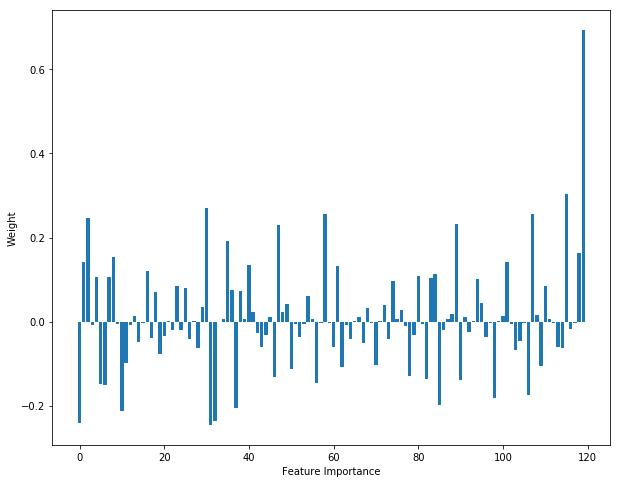

In [95]:
plt.figure(figsize=(10,8))
plt.xlabel('Feature Importance')
plt.ylabel('Weight')

plt.bar([_ for _ in range(len(lr.get_w()))],lr.get_w())

In [111]:
picture = [[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[12],[13],[14],[15],[16],[17],[18],[19],[20]]
picture_label = []
for i in picture:
    picture_label += i*6

In [103]:
xlabel = ['o','h','l','v','t','c']
xlabel

['o', 'h', 'l', 'v', 't', 'c']

In [112]:
# Scatter plot 
trace = go.Scatter(
    y = lr.get_w(),
    x = xlabel*20,
    mode='markers',
    name = 'Importance',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = lr.get_w(),
        colorscale='Portland',
        showscale=True
    ),
    text = xlabel*20
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Linear Regression Feature Importance on weight',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Feature name',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter1')

# Scatter plot 
trace = go.Scatter(
    y = lr.get_w(),
    x = xlabel*20,
    mode='markers',
    name = 'Day',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = picture_label,
        colorscale='Portland',
        showscale=True
    ),
    text = xlabel*20
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Linear Regression Feature Importance on day',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Feature name',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2')

# For five consecutive days price Prediction(not week)

## Make models of all the features of X

In [120]:
def load_data_feature(stock, seq_len,feature,day=0):
    amount_of_features = len(stock.columns) 
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:,-1,feature] 

    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1,feature]

    
    x_train = x_train.reshape((x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
    x_test =  x_test.reshape((x_test.shape[0],x_test.shape[1]*x_test.shape[2])) #shape(127,20,6) --> (127,120)
     

    return [x_train, y_train, x_test, y_test]

In [121]:
#transform the shape of features array into the shape of X data
def shape_transfrom(features):
    features_=[]
    for i in range(features.shape[1]):
        temp = np.array([])
        for feature in features:
            temp = np.hstack((temp,feature[i]))
        features_ .append(temp)
    
    features_ = np.array(features_)
    return features_

In [122]:
def make_features_model_first(stock,seq_len):
    amount_of_features = len(stock.columns)
    models = []
    errors = []
    features = []
    columns = stock.columns
    
    for i in range(amount_of_features): #load data and train
        x_train ,y_train ,x_test,y_test= load_data_feature(stock,seq_len,i)
        lr = LinearRegressionReg()
        lr.fit(x_train,y_train,0)
        models.append(lr)
        errors.append(lr.score(x_test,y_test))
        features.append(lr.predict(x_test))
        print("Eout of %s is %f"%(columns[i],errors[i]))
        
    features_ = shape_transfrom(np.array(features))
    
    return [features_,models,x_test,y_test]

In [123]:
def predict_features(x_test,model,amount_of_features):
    errors = []
    features = []
    
    for i in range(amount_of_features): #load data and train
#         errors.append(lr.score(x_test,y_test))
        features.append(model[i].predict(x_test))
    features = np.array(features)
    features_ = shape_transfrom(features)
    
    return features_ 
    

In [124]:
def fiveday_predict(stock,seq_len):
    amount_of_features = len(stock.columns)
    features,model,x_test,y_test = make_features_model_first(stock,seq_len)
    y_predict = []
    y_predict.append(features[:,-1]) #shape = (127,1)
    length = x_test.shape[0]
    
    for day in range(4): 
        #add the prediction of features
        x_test_temp = []
        for i in range(length):
            x_test_temp.append(np.concatenate((x_test[i],features[i])))
        x_test = np.array(x_test_temp)[:,amount_of_features:] #still use the recent 20 days data

        #Predict features
        features_1 = predict_features(x_test,model,amount_of_features)
        y_predict.append(features_1[:,-1]) #take the close price
    return [np.array(y_predict),y_test]
    

In [125]:
fiveday_predict ,y_test= fiveday_predict(Yunta50_N,20)
fiveday_predict.shape

Eout of open is 0.000287
Eout of high is 0.000327
Eout of low is 0.000464
Eout of volumn is 0.005012
Eout of Taiwan_50 is 0.000489
Eout of close is 0.000488


(5, 127)

In [126]:
def week_score(y_test,y_predict):
    length = y_test.shape[0]
    y_test = denormalize(Yunta50_,y_test).reshape((length))
    week_score_ = []
    for day in range(5):
        y_test_temp = y_test[day:]
        y_predict_temp = denormalize(Yunta50_,y_predict[day]).reshape((length))[:length-day]
        temp = np.array(list(map(lambda x,y:((y-abs(x-y))/y)*0.5,y_predict_temp,y_test_temp)))
        week_score_.append(temp[:length-4])
    week_score_ = np.array(week_score_)
    
    return [week_score_,sum(sum(week_score_))/(week_score_.shape[1]*1.0)]

In [127]:
fiveday_score_array,fiveday_score = week_score(y_test,fiveday_predict)
print('Average Fiveday_score is ',fiveday_score)

Average Fiveday_score is  2.4683655144544816


<BarContainer object of 123 artists>

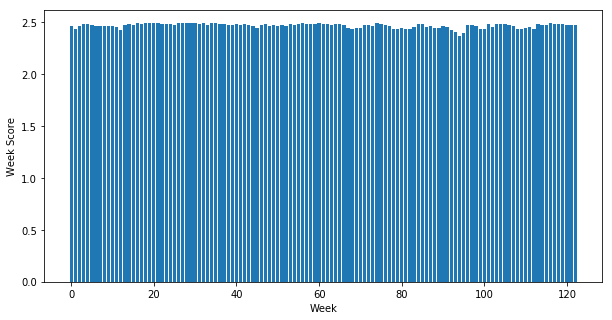

In [129]:
plt.figure(figsize=(10,5))
plt.xlabel('Week')
plt.ylabel('Week Score')
plt.bar([_ for _ in range(fiveday_score_array.shape[1])],sum(fiveday_score_array))